In [7]:
%matplotlib inline
# -*- coding: utf-8 -*-
"""
Created on Fri Apr 22 17:25:13 2016

@author: tabacof
"""

# Implements a variational autoencoder as described in Kingma et al. 2013
# "Auto-Encoding Variational Bayes"
import theano
theano.config.floatX = 'float32'
import theano.tensor as T
import numpy as np
import pandas as pd
import lasagne
from parmesan.distributions import log_normal2, kl_normal2_stdnormal
from parmesan.layers import SimpleSampleLayer
import time, shutil, os
import scipy
from scipy.io import loadmat
import matplotlib
import pylab as plt
from read_write_model import read_model, write_model

In [8]:
#settings
do_train_model = False
batch_size = 100
latent_size = 100
lr = 0.001
num_epochs = 50
model_filename = "svhn_conv_ae"
nplots = 5

np.random.seed(1234) # reproducibility

In [9]:
#SYMBOLIC VARS
sym_x = T.tensor4()
sym_lr = T.scalar('lr')

### LOAD DATA
print "Using SVHN dataset"

svhn_train = loadmat('train_32x32.mat')
svhn_test = loadmat('test_32x32.mat')

train_x = np.rollaxis(svhn_train['X'], 3).transpose(0,3,1,2).astype(theano.config.floatX)
test_x = np.rollaxis(svhn_test['X'], 3).transpose(0,3,1,2).astype(theano.config.floatX)

train_y = svhn_train['y'].flatten() - 1
test_y = svhn_test['y'].flatten() - 1

svhn_mean = 115.11177966923525
svhn_std = 50.819267906232888
train_x = (train_x - svhn_mean)/svhn_std
test_x = (test_x - svhn_mean)/svhn_std

n_train_batches = train_x.shape[0] / batch_size
n_test_batches = test_x.shape[0] / batch_size

#setup shared variables
sh_x_train = theano.shared(train_x, borrow=True)
sh_x_test = theano.shared(test_x, borrow=True)

Using SVHN dataset


In [10]:
### RECOGNITION MODEL q(z|x)
l_in = lasagne.layers.InputLayer((batch_size, 3, 32, 32))
l_noise = lasagne.layers.BiasLayer(l_in, b = np.zeros((3,32,32), dtype = np.float32), shared_axes = 0, name = "NOISE")
l_noise.params[l_noise.b].remove("trainable")
l_enc_h1 = lasagne.layers.Conv2DLayer(l_noise, num_filters = 32, filter_size = 4, stride = 2, nonlinearity = lasagne.nonlinearities.elu, name = 'ENC_CONV1')
l_enc_h1 = lasagne.layers.Conv2DLayer(l_enc_h1, num_filters = 64, filter_size = 4, stride = 2, nonlinearity = lasagne.nonlinearities.elu, name = 'ENC_CONV2')
l_enc_h1 = lasagne.layers.Conv2DLayer(l_enc_h1, num_filters = 128, filter_size = 4, stride = 2, nonlinearity = lasagne.nonlinearities.elu, name = 'ENC_CONV3')
l_enc_h1 = lasagne.layers.DenseLayer(l_enc_h1, num_units=512, nonlinearity=lasagne.nonlinearities.elu, name='ENC_DENSE2')

l_z = lasagne.layers.DenseLayer(l_enc_h1, num_units=latent_size, nonlinearity=lasagne.nonlinearities.identity, name='Z')

In [11]:
### GENERATIVE MODEL p(x|z)
l_dec_h1 = lasagne.layers.DenseLayer(l_z, num_units=512, nonlinearity=lasagne.nonlinearities.elu, name='DEC_DENSE1')
l_dec_h1 = lasagne.layers.ReshapeLayer(l_dec_h1, (batch_size, -1, 4, 4))
l_dec_h1 = lasagne.layers.TransposedConv2DLayer(l_dec_h1, num_filters = 128, crop="same",filter_size = 5, stride = 2, nonlinearity = lasagne.nonlinearities.elu, name = 'DEC_CONV1')
l_dec_h1 = lasagne.layers.TransposedConv2DLayer(l_dec_h1, num_filters = 64, crop="same",filter_size = 5, stride = 2, nonlinearity = lasagne.nonlinearities.elu, name = 'DEC_CONV2')
l_dec_h1 = lasagne.layers.TransposedConv2DLayer(l_dec_h1, num_filters = 32, filter_size = 5, stride = 2, nonlinearity = lasagne.nonlinearities.elu, name = 'DEC_CONV3')
l_dec_x = lasagne.layers.TransposedConv2DLayer(l_dec_h1, num_filters = 3,filter_size = 4, nonlinearity = lasagne.nonlinearities.identity, name = 'DEC_MU')
l_dec_x = lasagne.layers.ReshapeLayer(l_dec_x, (batch_size, -1))

# Get outputs from model
dec_x = lasagne.layers.get_output(l_dec_x, sym_x, deterministic=False)

In [12]:
loss = lasagne.objectives.squared_error(dec_x, sym_x.reshape((batch_size, -1)))
loss = lasagne.objectives.aggregate(loss, mode="mean")

params = lasagne.layers.get_all_params(l_dec_x, trainable=True)
for p in params:
    print p, p.get_value().shape

### Take gradient of Negative LogLikelihood
grads = T.grad(loss, params)

# Add gradclipping to reduce the effects of exploding gradients.
# This speeds up convergence
clip_grad = 1
max_norm = 5
mgrads = lasagne.updates.total_norm_constraint(grads,max_norm=max_norm)
cgrads = [T.clip(g,-clip_grad, clip_grad) for g in mgrads]

ENC_CONV1.W (32, 3, 4, 4)
ENC_CONV1.b (32,)
ENC_CONV2.W (64, 32, 4, 4)
ENC_CONV2.b (64,)
ENC_CONV3.W (128, 64, 4, 4)
ENC_CONV3.b (128,)
ENC_DENSE2.W (512, 512)
ENC_DENSE2.b (512,)
Z.W (512, 100)
Z.b (100,)
DEC_DENSE1.W (100, 512)
DEC_DENSE1.b (512,)
DEC_CONV1.W (32, 128, 5, 5)
DEC_CONV1.b (128,)
DEC_CONV2.W (128, 64, 5, 5)
DEC_CONV2.b (64,)
DEC_CONV3.W (64, 32, 5, 5)
DEC_CONV3.b (32,)
DEC_MU.W (32, 3, 4, 4)
DEC_MU.b (3,)


In [13]:
#Setup the theano functions
sym_batch_index = T.iscalar('index')
batch_slice = slice(sym_batch_index * batch_size, (sym_batch_index + 1) * batch_size)

updates = lasagne.updates.adam(cgrads, params, learning_rate=sym_lr)

train_model = theano.function([sym_batch_index, sym_lr], loss, updates=updates,
                                  givens={sym_x: sh_x_train[batch_slice]},)

test_model = theano.function([sym_batch_index], loss,
                                  givens={sym_x: sh_x_test[batch_slice]},)

plot_results = theano.function([sym_batch_index], dec_x,
                                  givens={sym_x: sh_x_test[batch_slice]},)

def train_epoch(lr):
    costs = []
    for i in range(n_train_batches):
        cost_batch = train_model(i, lr)
        costs += [cost_batch]
    return np.mean(costs)


def test_epoch():
    costs = []
    for i in range(n_test_batches):
        cost_batch = test_model(i)
        costs += [cost_batch]
    return np.mean(costs)

In [14]:
if do_train_model:
    # Training Loop
    for epoch in range(num_epochs):
        start = time.time()

        #shuffle train data, train model and test model
        np.random.shuffle(train_x)
        sh_x_train.set_value(train_x)
        
        results = plot_results(0)
        plt.figure(figsize=(2, nplots))
        for i in range(0,nplots):
            plt.subplot(nplots,2,(i+1)*2-1)
            plt.imshow((svhn_std*test_x[i].transpose(1,2,0)+svhn_mean)/255.0)
            plt.axis('off')
            plt.subplot(nplots,2,(i+1)*2)
            plt.imshow((svhn_std*results[i].reshape(3,32,32).transpose(1,2,0)+svhn_mean)/255.0)
            plt.axis('off')
        plt.show()
            
        train_cost = train_epoch(lr)
        test_cost = test_epoch()

        t = time.time() - start

        line =  "*Epoch: %i\tTime: %0.2f\tLR: %0.5f\tLL Train: %0.3f\tLL test: %0.3f\t" % ( epoch, t, lr, train_cost, test_cost)
        print line
    
    print "Write model data"
    write_model(l_dec_x, model_filename)
else:
    read_model(l_dec_x, model_filename)
    

In [15]:
l_z, reconstruction = lasagne.layers.get_output([l_z, l_dec_x], inputs = sym_x, deterministic=True)
# Adversarial confusion cost function
    
# Mean squared reconstruction difference
# KL divergence between latent variables
adv_z =  T.vector()
adv_confusion = lasagne.objectives.squared_error(adv_z, l_z).sum()

# Adversarial regularization
C = T.scalar()
adv_reg = C*lasagne.regularization.l2(l_noise.b)
# Total adversarial loss
adv_loss = adv_confusion + adv_reg
adv_grad = T.grad(adv_loss, l_noise.b)

# Function used to optimize the adversarial noise
adv_function = theano.function([sym_x, adv_z, C], [adv_loss, adv_grad])

# Helper to plot reconstructions    
adv_plot = theano.function([sym_x], reconstruction)

# Function to get latent variables of the target
adv_l_z = theano.function([sym_x], l_z)

In [16]:
def show_svhn(img, i, title=""): # expects flattened image of shape (3072,) 
    img = img.copy().reshape(3,32,32).transpose(1,2,0)
    img *= svhn_std
    img += svhn_mean
    img /= 255.0
    img = np.clip(img, 0, 1)
    plt.subplot(3, 2, i)
    plt.imshow(img)
    plt.title(title)
    plt.axis("off")
    
def svhn_input(img):
    return np.tile(img, (batch_size, 1, 1, 1)).reshape(batch_size, 3, 32, 32)

def svhn_dist(img1, img2):
    img1_pixels = img1.flatten()*svhn_std + svhn_mean
    img2_pixels = img2.flatten()*svhn_std + svhn_mean
    return np.linalg.norm(img1_pixels - img2_pixels)

In [23]:
def adv_test(orig_img = 0, target_img = 1, C = 200.0, plot = True):
    # Set the adversarial noise to zero
    l_noise.b.set_value(np.zeros((3,32,32)).astype(np.float32))
    
    # Get latent variables of the target
    adv_target_z = adv_l_z(svhn_input(test_x[target_img]))
    adv_target_z = adv_target_z[0]

    original_reconstruction = adv_plot(svhn_input(test_x[orig_img]))[0]
    target_reconstruction = adv_plot(svhn_input(test_x[target_img]))[0]

    orig_recon_dist = svhn_dist(original_reconstruction, test_x[orig_img])
    target_recon_dist = svhn_dist(target_reconstruction, test_x[target_img])
    orig_target_recon_dist = svhn_dist(original_reconstruction, test_x[target_img])
    target_orig_recon_dist = svhn_dist(target_reconstruction, test_x[orig_img])

    # Plot original reconstruction    
    if plot:
        plt.figure(figsize=(10,10))
        show_svhn(test_x[orig_img], 1, "Original image")
        show_svhn(original_reconstruction, 2, "Original reconstruction")

    # Initialize the adversarial noise for the optimization procedure
    l_noise.b.set_value(np.random.uniform(-1e-8, 1e-8, size=(3,32,32)).astype(np.float32))
    
    # Optimization function for L-BFGS-B
    def fmin_func(x):
        l_noise.b.set_value(x.reshape(3, 32, 32).astype(np.float32))
        f, g = adv_function(svhn_input(test_x[orig_img]), adv_target_z, C)
        return float(f), g.flatten().astype(np.float64)
        
    # Noise bounds (pixels cannot exceed 0-1)
    bounds = zip(-svhn_mean/svhn_std-test_x[orig_img].flatten(), (255.0-svhn_mean)/svhn_std-test_x[orig_img].flatten())
    
    # L-BFGS-B optimization to find adversarial noise
    x, f, d = scipy.optimize.fmin_l_bfgs_b(fmin_func, l_noise.b.get_value().flatten(), bounds = bounds, fprime = None, factr = 10, m = 25)
    
    adv_img = adv_plot(svhn_input(test_x[orig_img]))[0]
    
    orig_dist = svhn_dist(adv_img, test_x[orig_img])
    adv_dist = svhn_dist(adv_img, test_x[target_img])
    recon_dist = svhn_dist(adv_img, test_x[orig_img]+x.reshape(3, 32, 32))

    # Plotting results
    if plot:
        show_svhn(x, 3, "Adversarial noise")
        show_svhn(test_x[target_img], 4, "Target image")
        show_svhn((test_x[orig_img].flatten()+x), 5, "Adversarial image")
        show_svhn(adv_img, 6, "Adversarial reconstruction")
    
        plt.show()
            
    orig_target_dist = np.linalg.norm(test_x[orig_img] - test_x[target_img])

    returns = (np.linalg.norm(x),
               orig_dist, 
               adv_dist, 
               orig_recon_dist, 
               target_recon_dist, 
               recon_dist,
               orig_target_dist,
               orig_target_recon_dist,
               target_orig_recon_dist)
    
    return returns

In [31]:
def orig_adv_dist(orig_img = None, target_img = None, plot = False, bestC = None):
    if orig_img is None:
        orig_img = np.random.randint(0, len(test_x))
    if target_img is None:
        target_label = test_y[orig_img]
        while target_label == test_y[orig_img]:
            target_img = np.random.randint(0, len(test_x))
            target_label = test_y[target_img]
    
    noise_dist = []
    orig_dist=[]
    adv_dist=[]
    target_recon_dist=[]
    recon_dist=[]
    orig_target_dist=[]
    orig_target_recon_dist=[]
    target_orig_recon_dist=[]
    
    C = np.logspace(-20, 20, 100, base = 2, dtype = np.float32)
    
    for c in C:
        noise, od, ad, ore, tre, recd, otd, otrd, tord = adv_test(orig_img, target_img, C=c, plot = False)
        noise_dist.append(noise)
        orig_dist.append(od)
        adv_dist.append(ad)
        target_recon_dist.append(tre)
        recon_dist.append(recd)
        orig_target_dist.append(otd)
        orig_target_recon_dist.append(otrd)
        target_orig_recon_dist.append(tord)

    noise_dist = np.array(noise_dist)
    orig_dist = np.array(orig_dist)
    adv_dist = np.array(adv_dist)
    target_recon_dist = np.array(target_recon_dist)
    recon_dist = np.array(recon_dist)
    orig_target_dist = np.array(orig_target_dist)
    orig_target_recon_dist = np.array(orig_target_recon_dist)
    target_orig_recon_dist = np.array(target_orig_recon_dist)
    
    if bestC is None:
        bestC = C[np.argmax(adv_dist - orig_dist >= 0)-1]

    print orig_img, target_img, bestC

    best_noise, best_orig_dist, best_adv_dist, orig_reconstruction_dist, target_reconstruction_dist, _, _, _, _ = adv_test(orig_img, target_img, C=bestC, plot = plot)

    if plot:
        plt.figure()
        plt.axhline(y=target_reconstruction_dist, linewidth = 2, color = 'cyan', label = "Target reconstruction - Target")
        plt.axvline(x=orig_reconstruction_dist, linewidth = 2, color='DarkOrange', label = "Original reconstruction - Original")
        plt.scatter(orig_dist, adv_dist)
        plt.scatter([best_orig_dist], [best_adv_dist], color = "red")
        plt.ylabel("Adversarial distortion")
        plt.xlabel("Adversarial - Original")
        plt.legend()
        plt.plot()
        
        plt.figure()
        plt.axhline(y=target_reconstruction_dist, linewidth = 2, color = 'cyan', label = "Target reconstruction - Target")
        plt.axvline(x=np.linalg.norm(test_x[orig_img]-test_x[target_img]), linewidth = 2, color='DarkOrange', label = "Original - Target")
        plt.scatter(noise_dist, adv_dist)
        plt.scatter([best_noise], [best_adv_dist], color = "red")
        plt.ylabel("Adversarial reconstruction - Target")
        plt.xlabel("Adversarial - Original")
        plt.legend()
        plt.plot()
        
    df = pd.DataFrame({'orig_img': orig_img,
                       'target_img': target_img,
                       'bestC': bestC,
                       'orig_reconstruction_dist': orig_reconstruction_dist,
                       'target_reconstruction_dist': target_reconstruction_dist,
                       'noise_dist': noise_dist,
                       'orig_dist': orig_dist,
                       'adv_dist': adv_dist,
                       'target_recon_dist': target_recon_dist,
                       'recon_dist': recon_dist,
                       'orig_target_dist': orig_target_dist,
                       'orig_target_recon_dist': orig_target_recon_dist,
                       'target_orig_recon_dist': target_orig_recon_dist,
                       'C': C})
    
    return df

7712 8130 33.1401


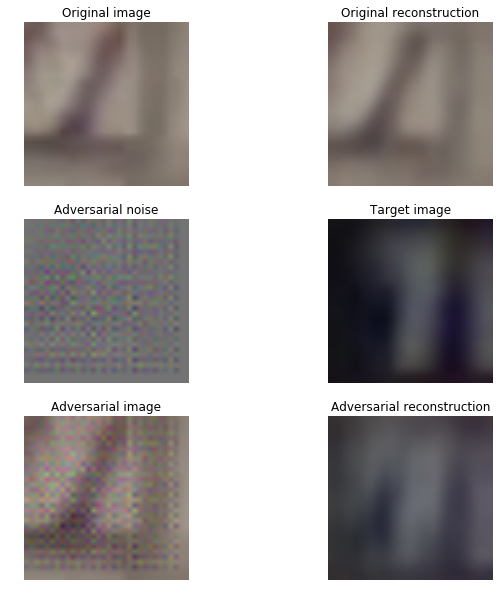

Iter 0 Time 280.32477808 sec
23886 1056 76.7783


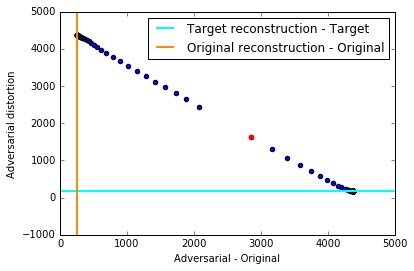

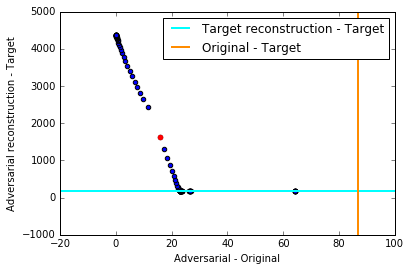

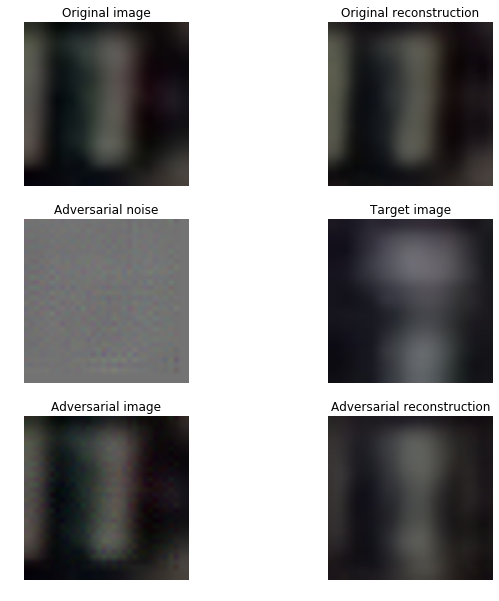

Iter 1 Time 122.489068031 sec
21955 763 76.7783


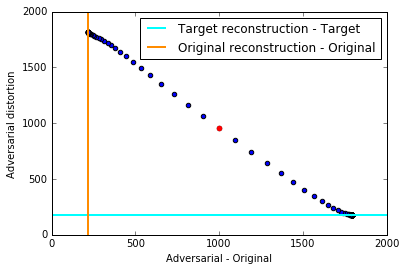

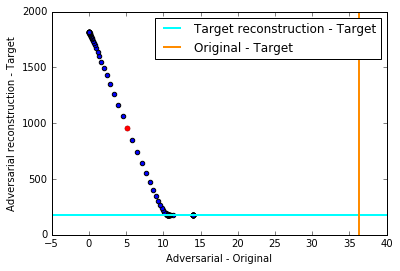

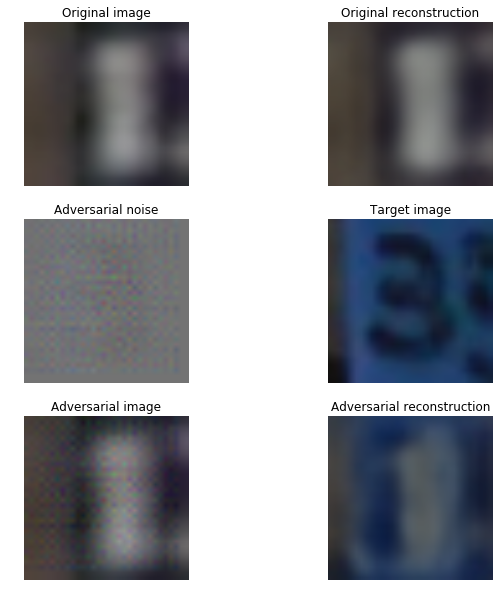

Iter 2 Time 164.588983059 sec
14444 9000 58.0243


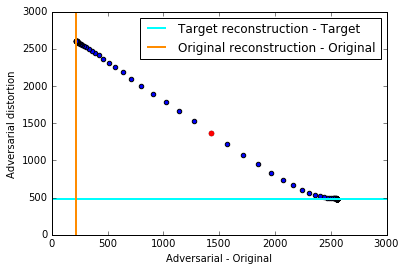

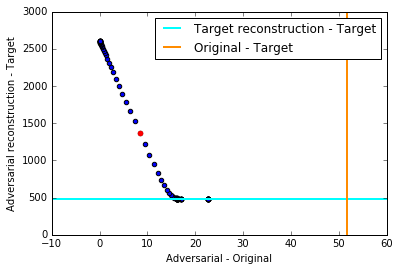

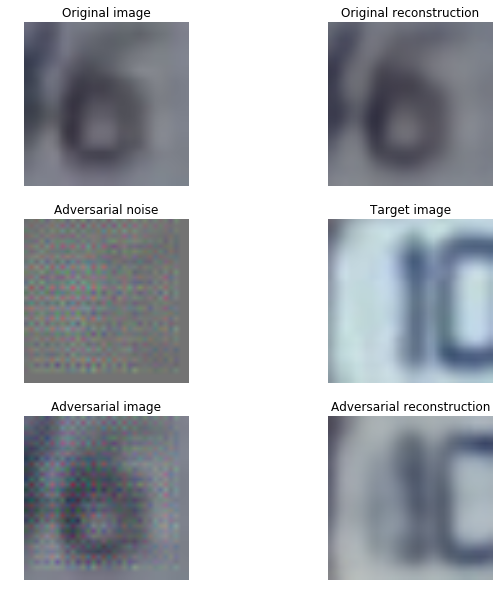

Iter 3 Time 147.885044813 sec
15381 24052 101.594


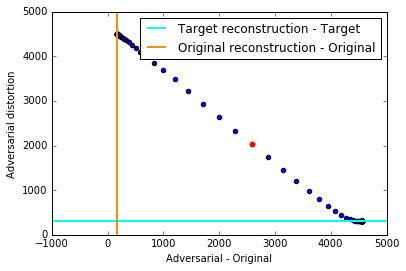

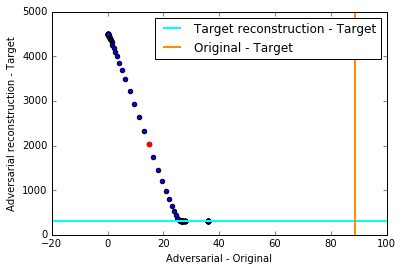

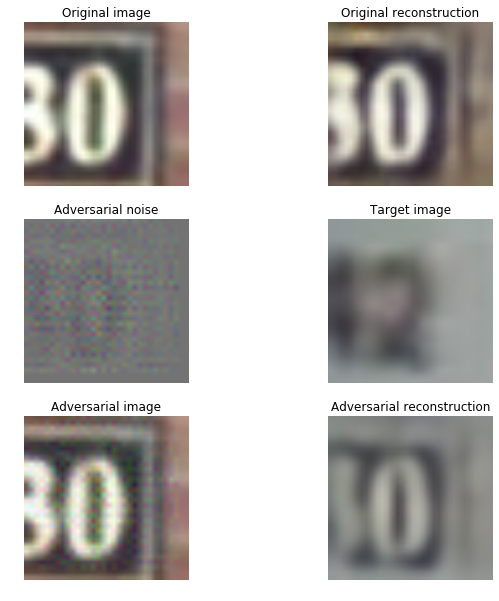

Iter 4 Time 283.364467859 sec
9526 2531 76.7783


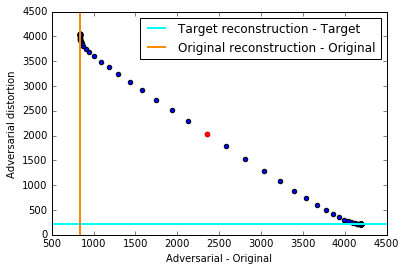

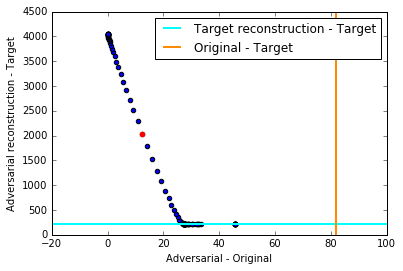

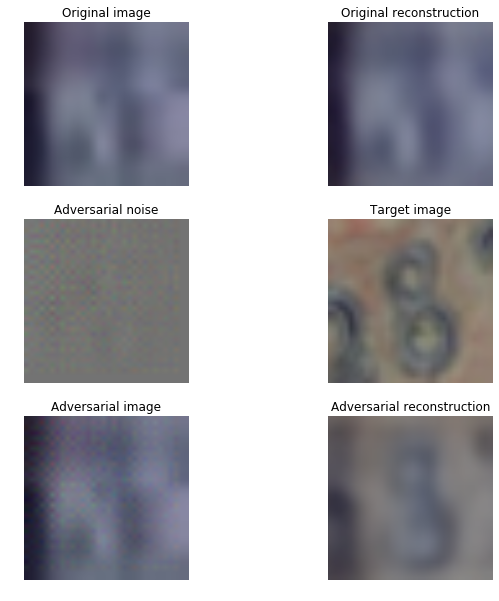

Iter 5 Time 140.636138916 sec
18338 25559 76.7783


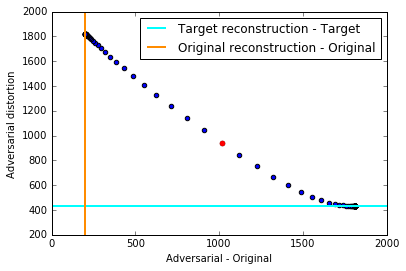

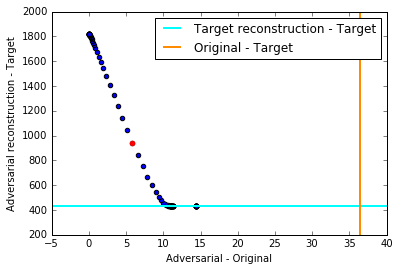

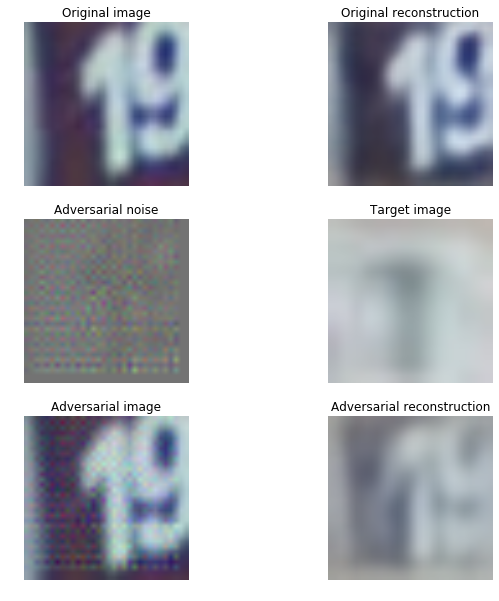

Iter 6 Time 159.707432985 sec
5280 735 76.7783


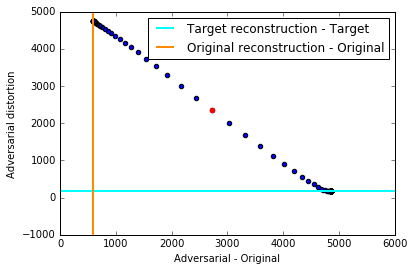

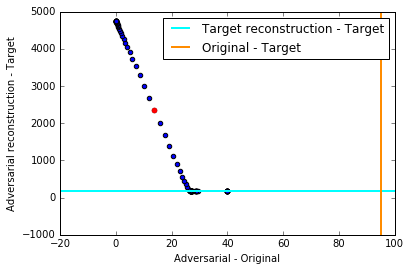

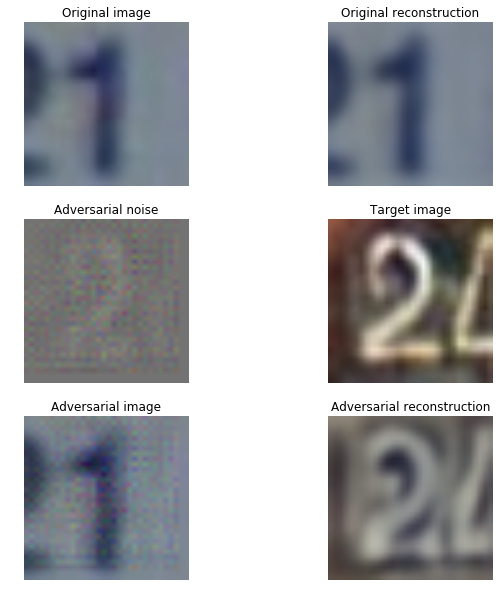

Iter 7 Time 184.994487047 sec
7015 25378 76.7783


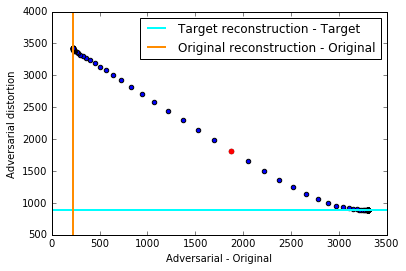

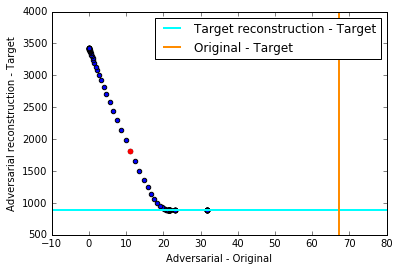

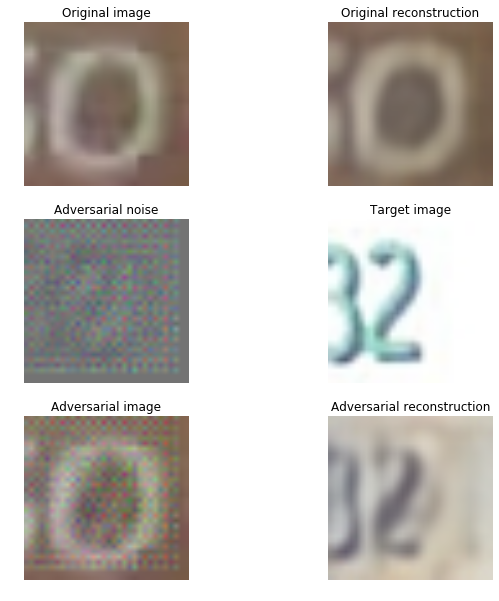

Iter 8 Time 132.371705055 sec
23585 17860 58.0243


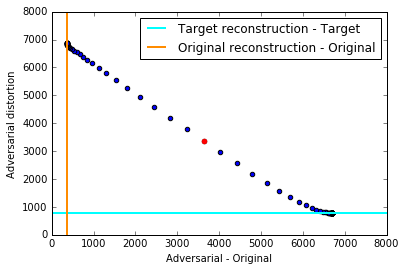

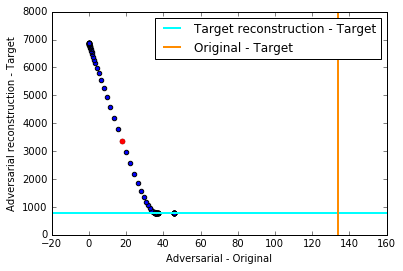

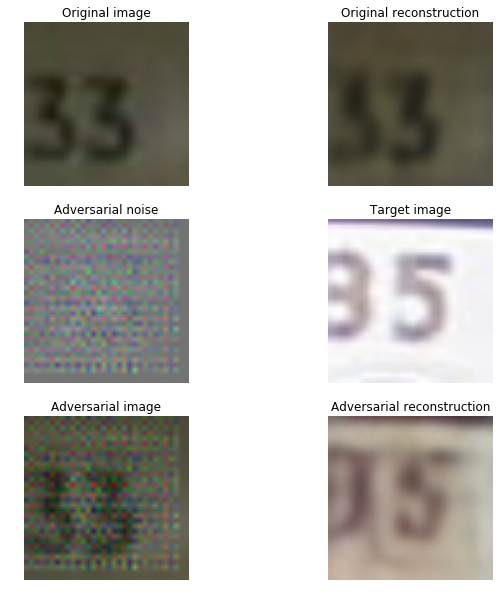

Iter 9 Time 198.342808962 sec
13113 1272 76.7783


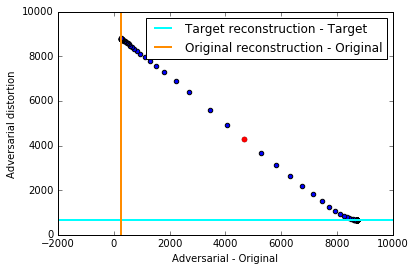

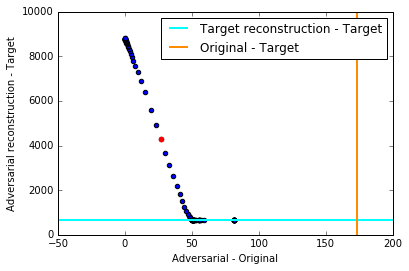

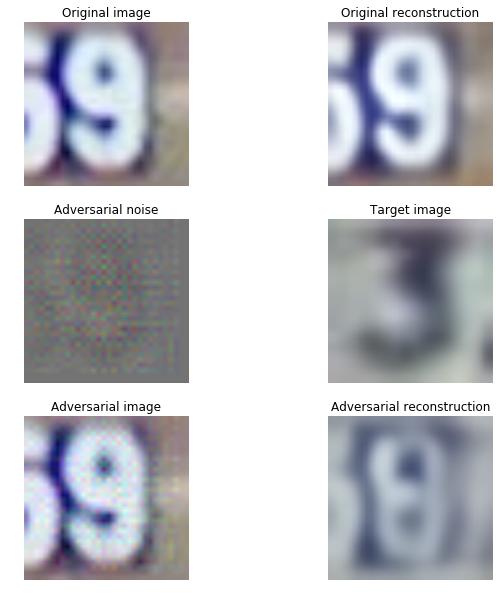

Iter 10 Time 229.529309034 sec
19907 22009 43.8512


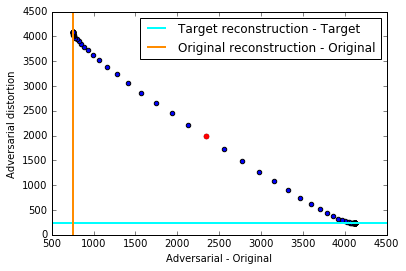

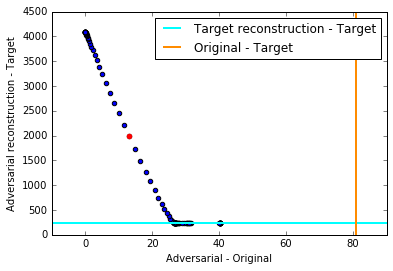

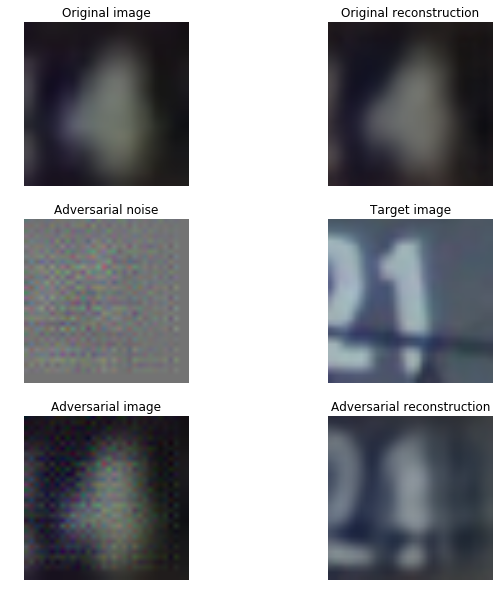

Iter 11 Time 222.304703951 sec
17872 17207 134.43


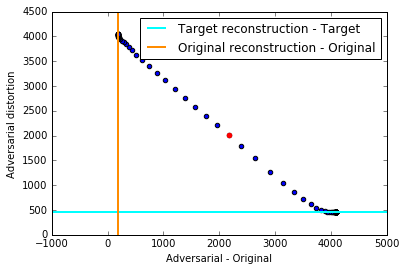

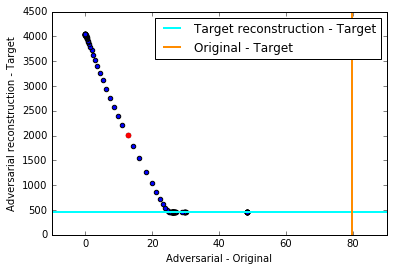

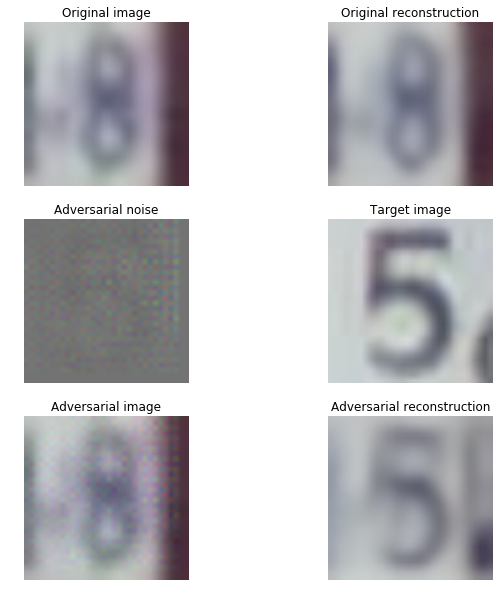

Iter 12 Time 108.243927002 sec
21642 5354 177.878


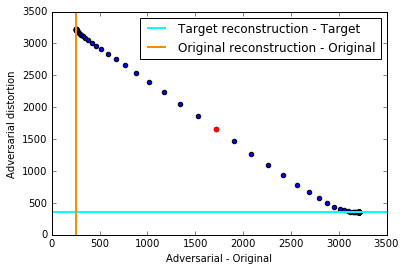

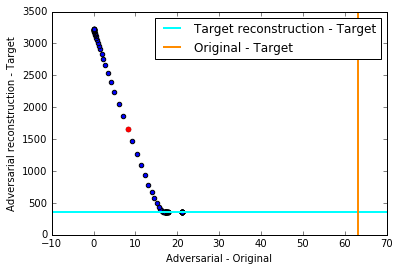

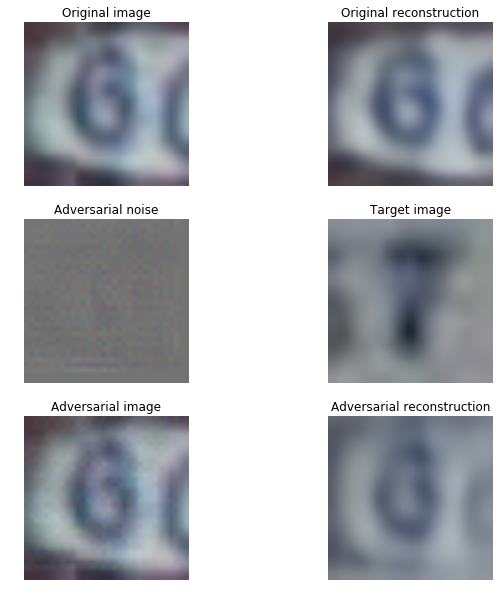

Iter 13 Time 123.455616951 sec
13573 25105 58.0243


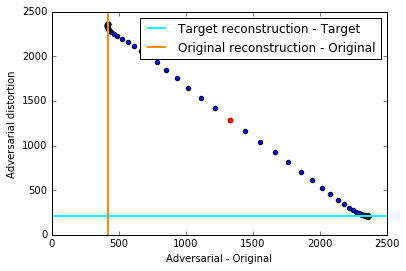

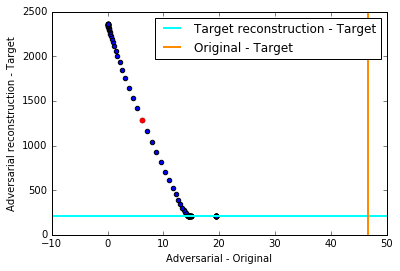

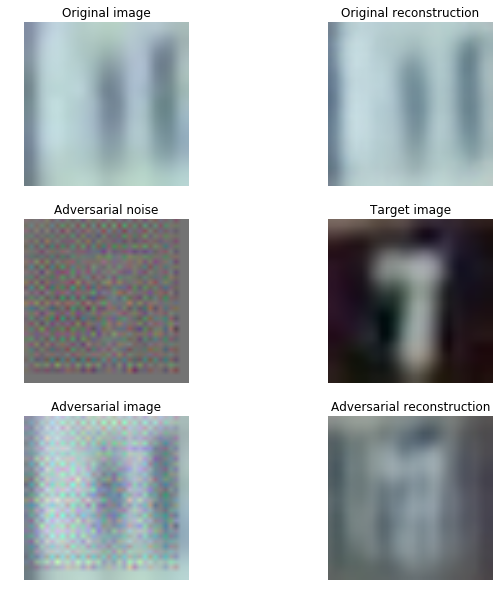

Iter 14 Time 324.61365509 sec
20427 4871 76.7783


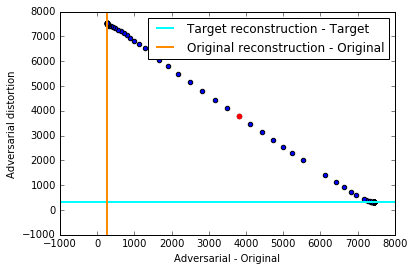

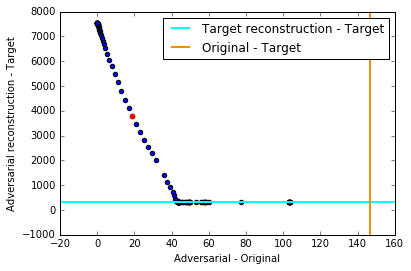

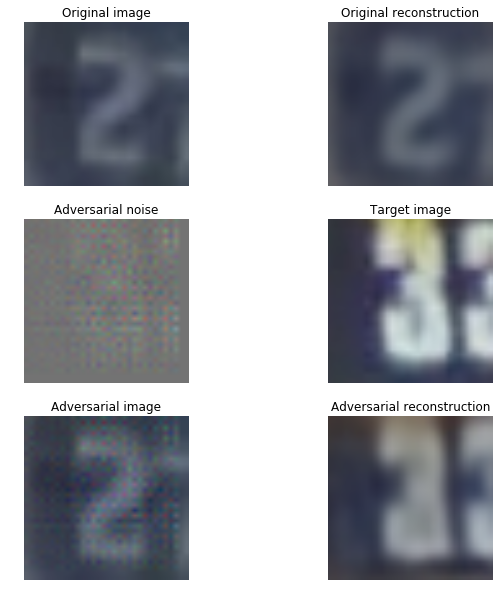

Iter 15 Time 109.787042856 sec
24064 6145 33.1401


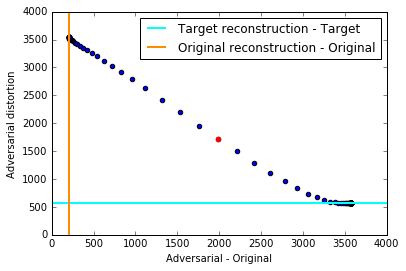

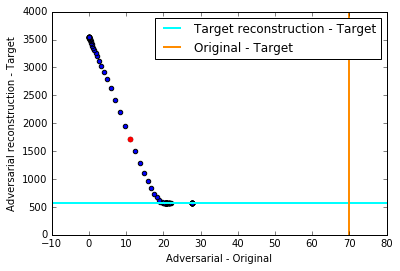

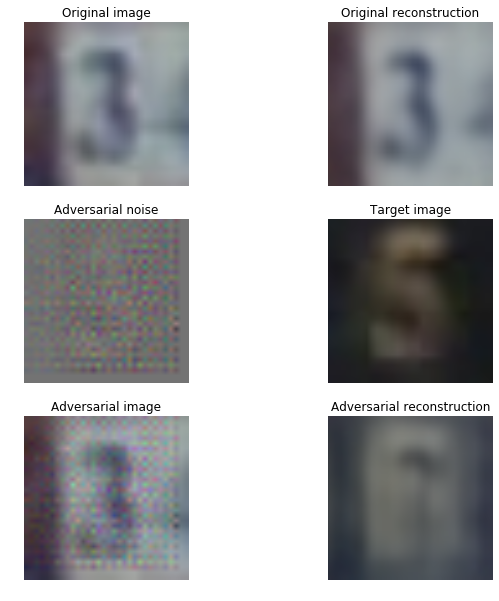

Iter 16 Time 270.509082794 sec
19009 4542 43.8512


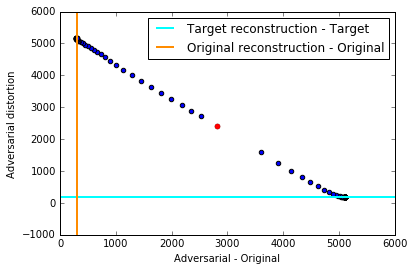

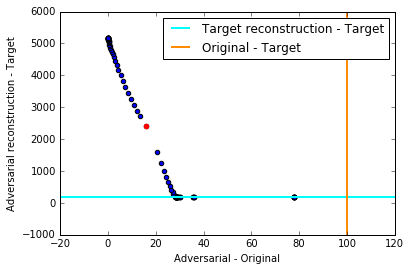

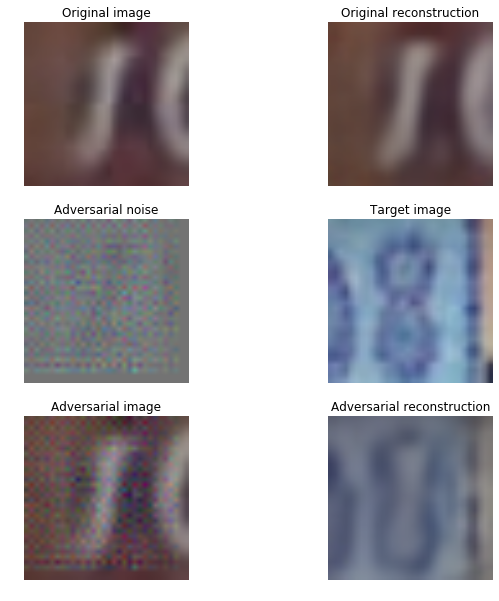

Iter 17 Time 163.660617113 sec
4319 13882 76.7783


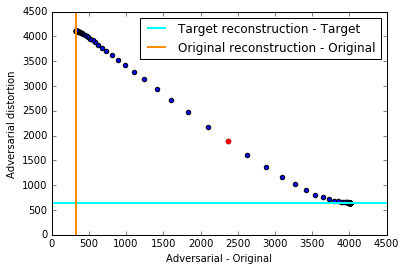

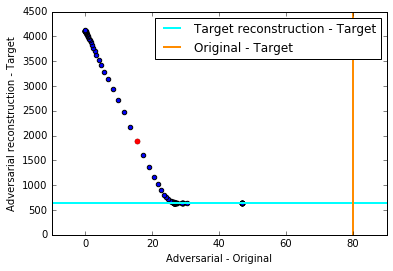

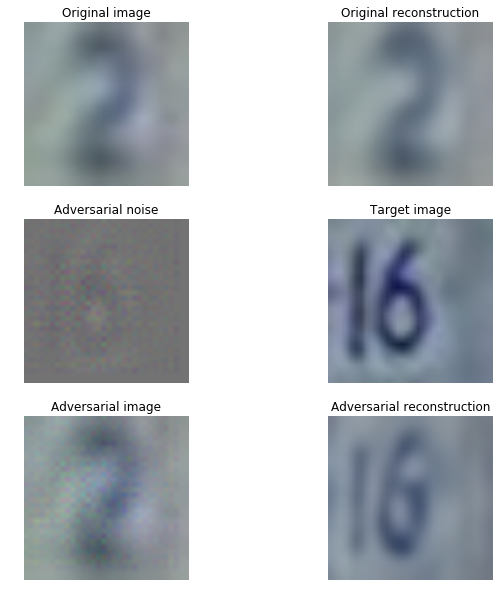

Iter 18 Time 101.617177963 sec
11807 18216 76.7783


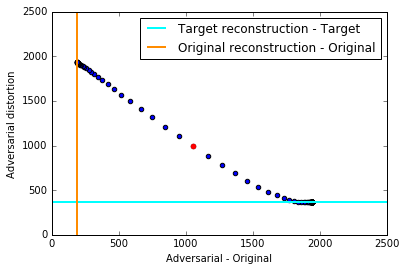

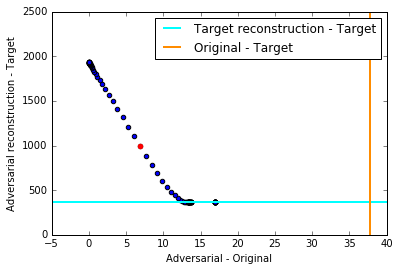

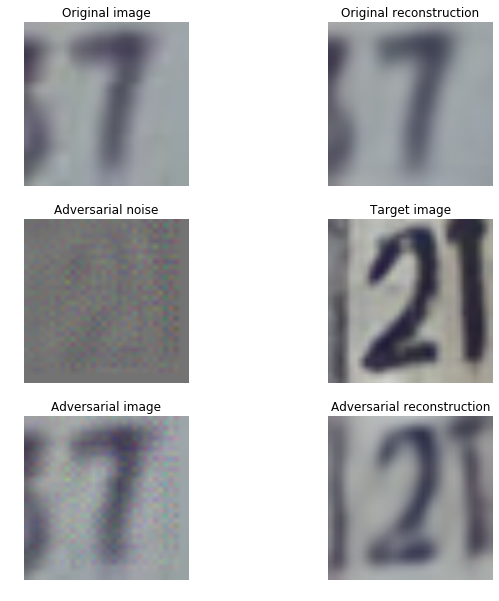

Iter 19 Time 117.950382948 sec
14792 13878 58.0243


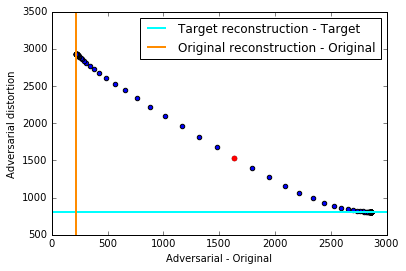

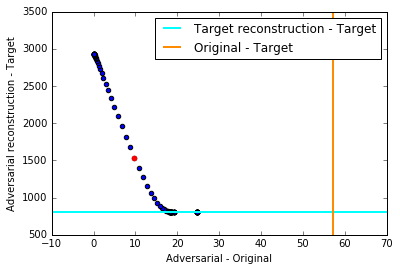

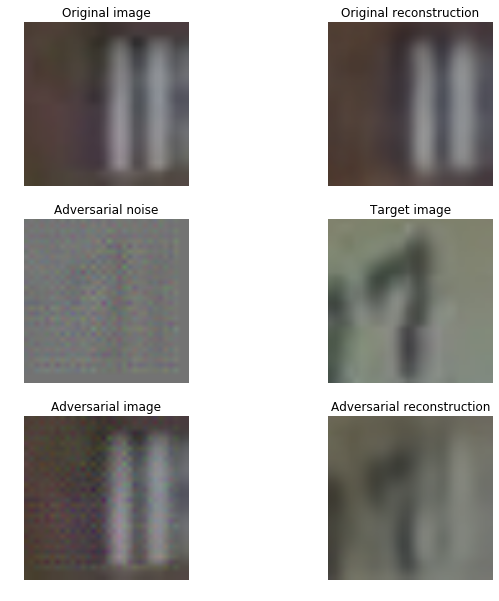

Iter 20 Time 132.969032049 sec
25864 7594 58.0243


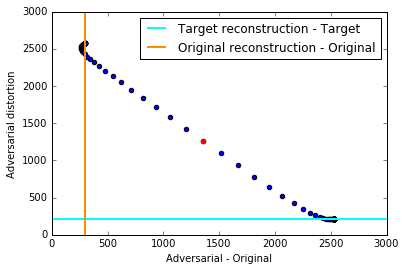

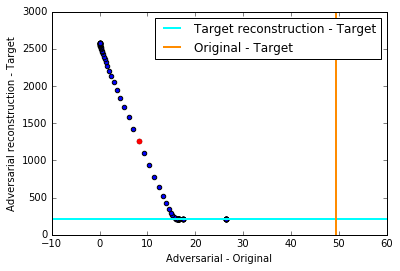

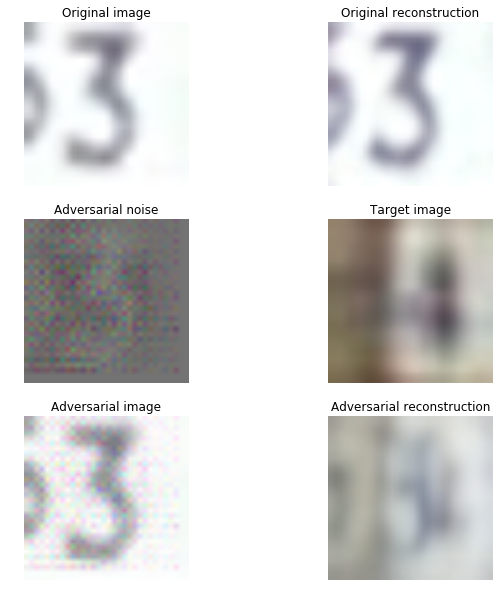

Iter 21 Time 194.160809994 sec
17963 760 58.0243


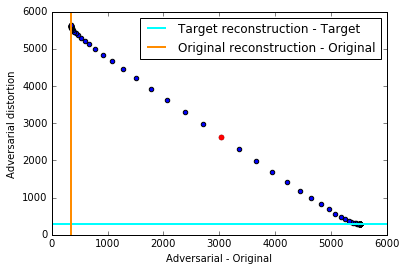

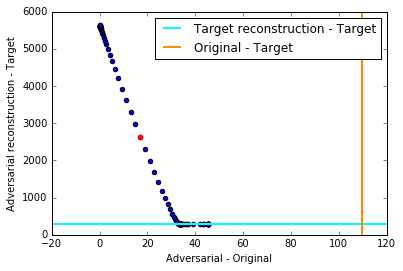

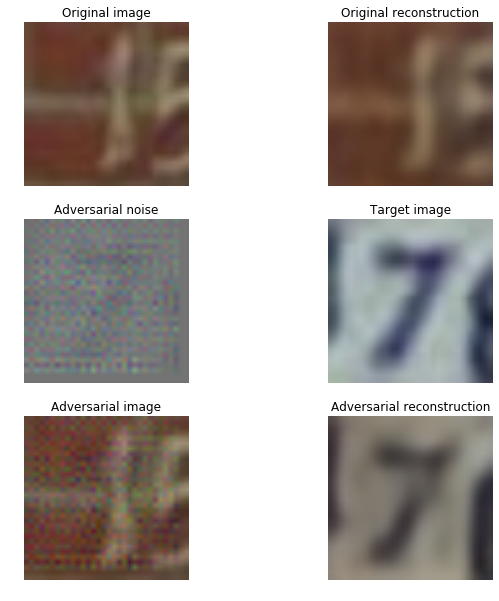

Iter 22 Time 146.163156986 sec
5911 8175 76.7783


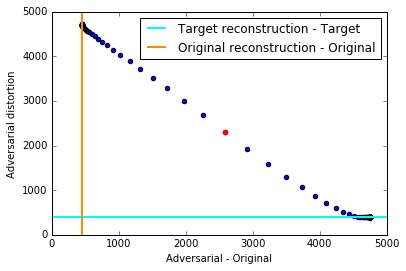

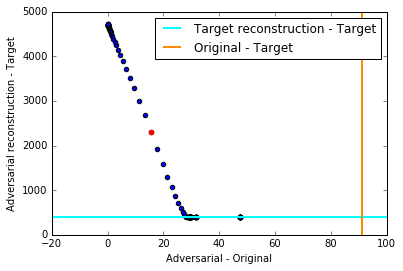

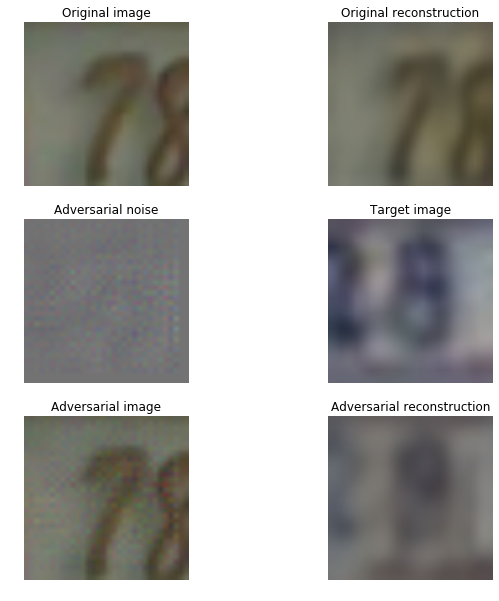

Iter 23 Time 105.59966898 sec
10967 18961 58.0243


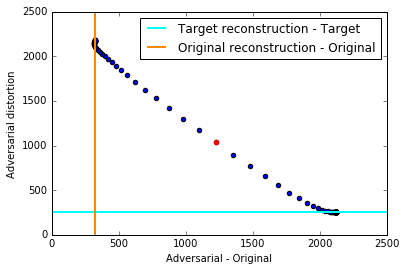

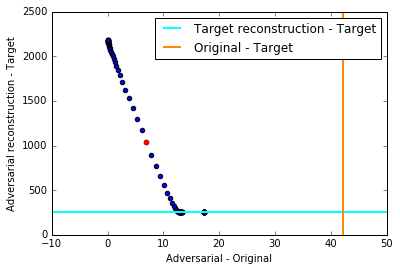

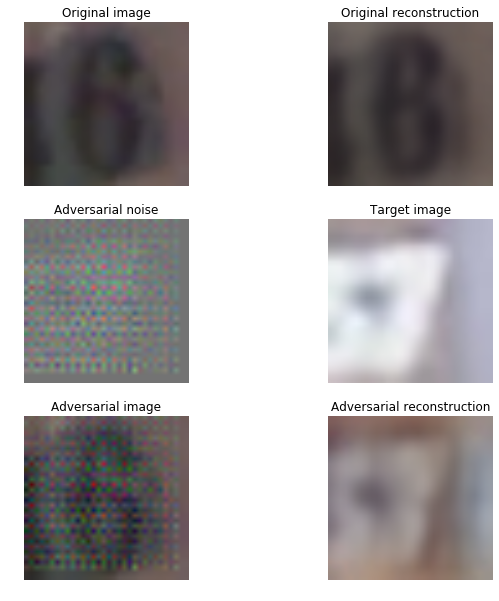

Iter 24 Time 193.97608304 sec


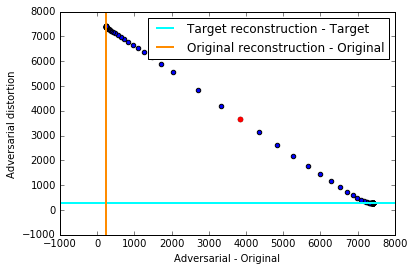

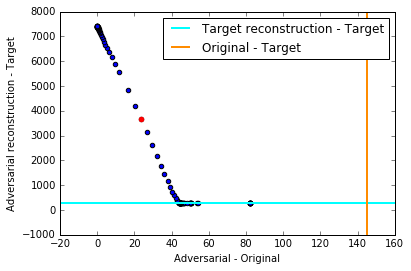

In [32]:
n = 25

for i in range(n):
    start_time = time.time()
    df = orig_adv_dist(plot = True)
    print "Iter", i, "Time", time.time() - start_time, "sec"
    df.to_csv("results/" + model_filename + "/exp_" + str(i) + ".csv")